# Converting prices to returns

Take the close prices and then calculate returns

In [7]:
import pandas as pd
import yfinance as yf
import numpy as np

In [8]:
df = yf.download('AAPL',
                 start='2000-01-01',
                 end='2010-12-31',
                 progress=False)

df = df.loc[:, ['Adj Close']]

df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

In [9]:
df.head()

,adj_close
Date,
2000-01-03,0.844981
2000-01-04,0.773741
2000-01-05,0.785063
2000-01-06,0.717125
2000-01-07,0.751094


Compute returns

In [10]:
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

df.head()

,adj_close,simple_rtn,log_rtn
Date,,,
2000-01-03,0.844981,NaN,NaN
2000-01-04,0.773741,-0.084310,-0.088077
2000-01-05,0.785063,0.014633,0.014527
2000-01-06,0.717125,-0.086538,-0.090514
2000-01-07,0.751094,0.047369,0.046281


In [11]:
df.to_csv('/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/AAPL_data_adj_rtn.csv', index=True)

adjusting the frequency calculating the Realized Volatility.

In [5]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn-v0_8')
# plt.style.use('seaborn-colorblind') #alternative
# plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

                  rv
Date                
2000-01-31  0.818381
2000-02-29  0.512135
2000-03-31  0.843825
2000-04-30  0.736167
2000-05-31  0.640823


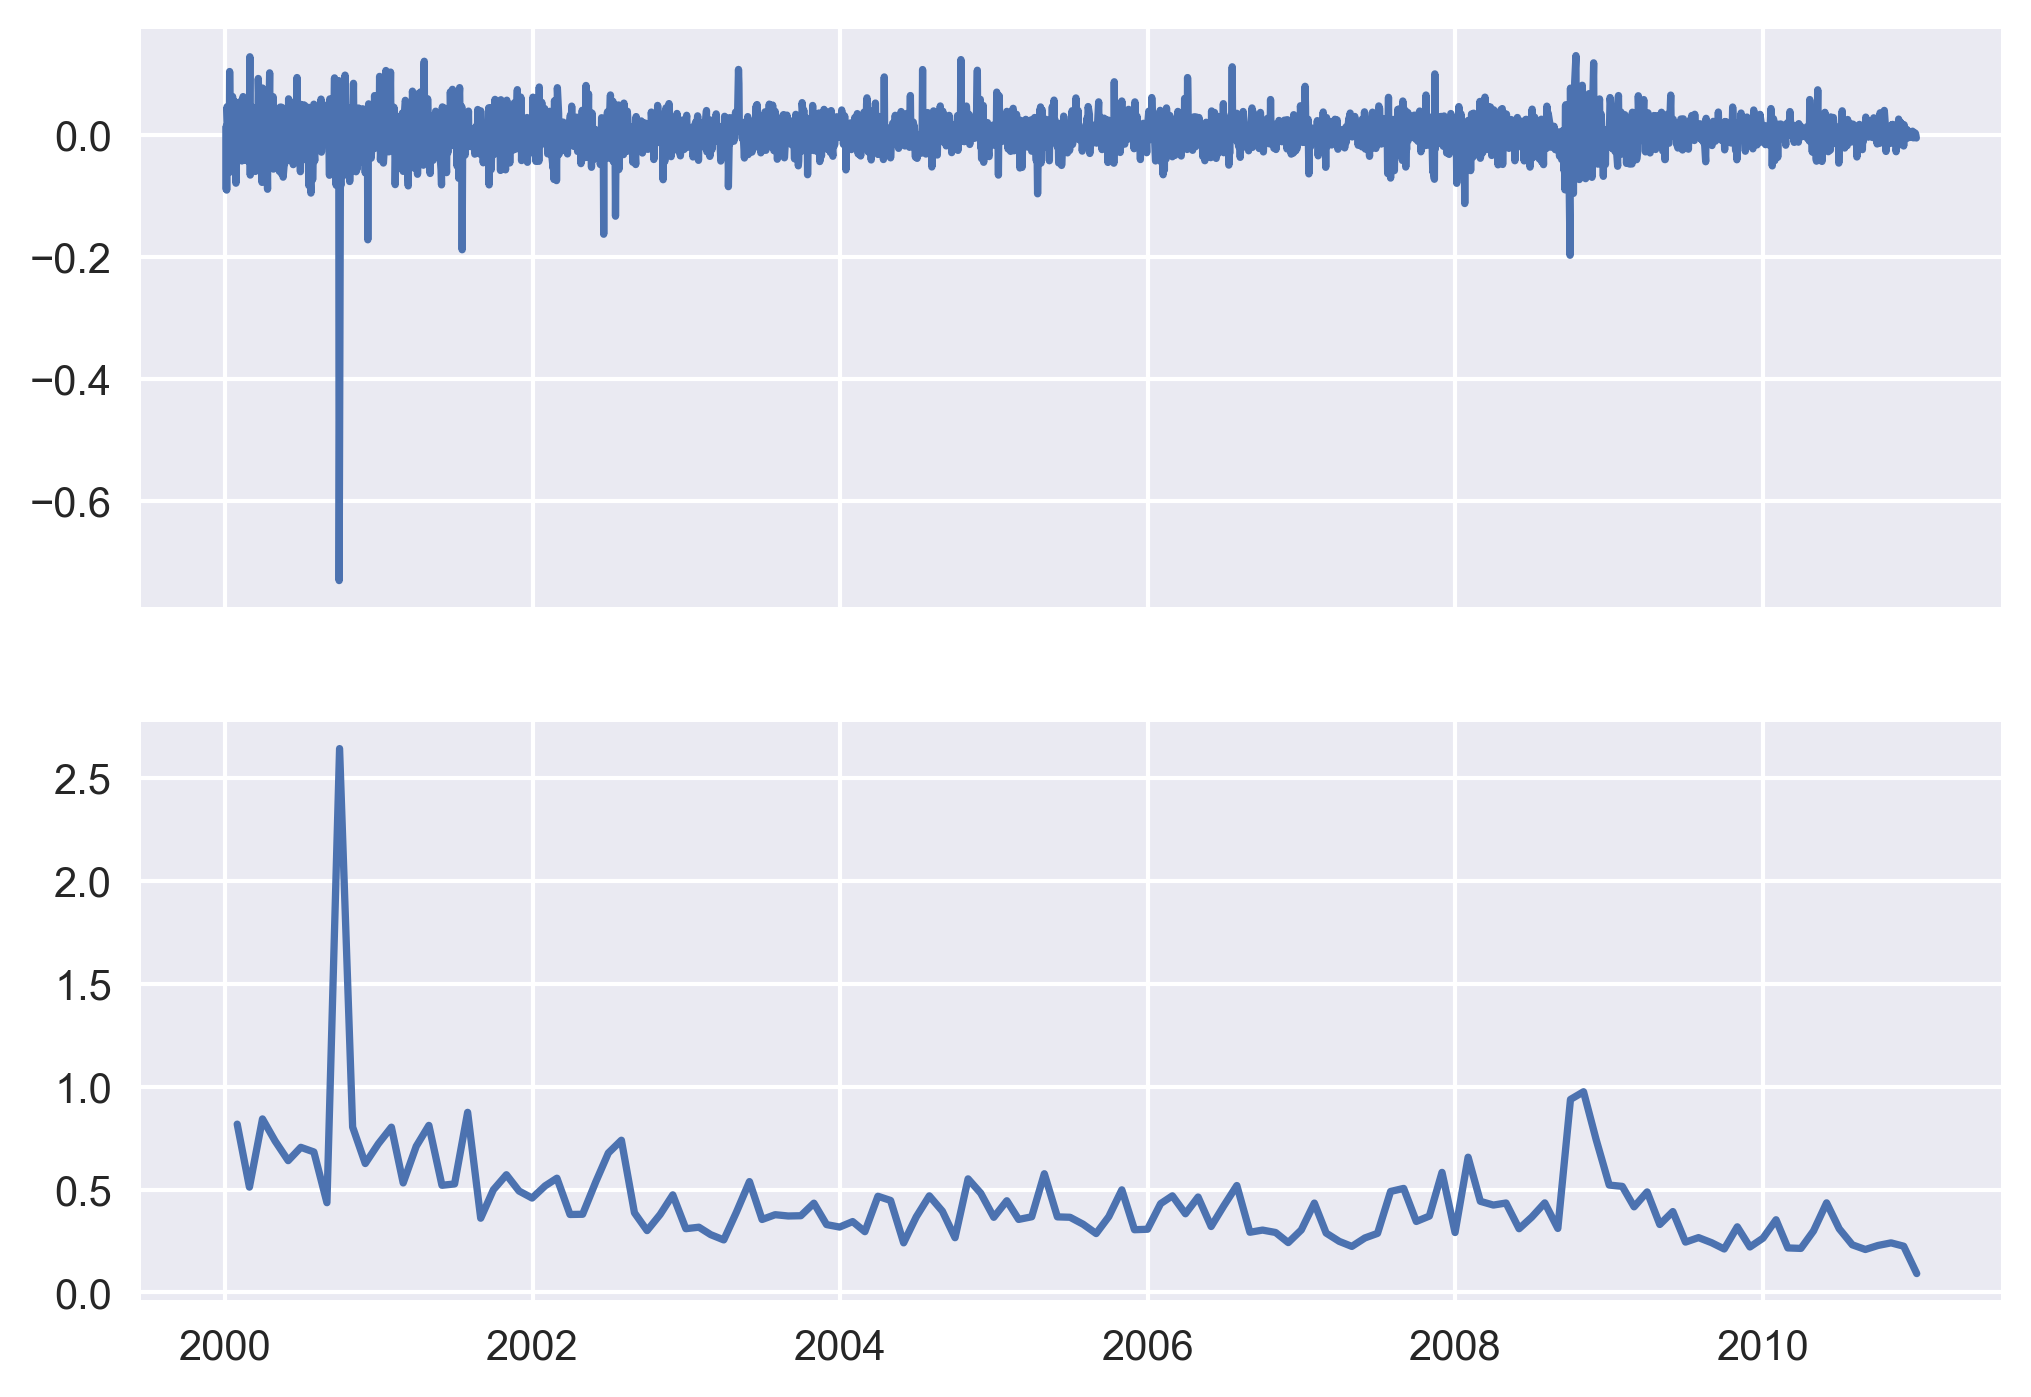

In [6]:
def realized_volatility(x):

    return np.sqrt(np.sum(x**2, axis = 0))

df_rv = df.groupby(pd.Grouper(freq='ME'))['log_rtn'].apply(realized_volatility) 
# Rename the Series
df_rv.rename('rv', inplace=True)  # Change the name of the Series

df_rv = df_rv.reset_index()
df_rv.rename(columns={'log_rtn': 'rv'}, inplace=True)  # Now renaming the DataFrame column

# Convert the Series to a DataFrame and reset the index


df_rv.rv = df_rv.rv * np.sqrt(12)
df_rv.set_index('Date', inplace=True)
print(df_rv.head())
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 1, sharex=True) 
ax[0].plot(df["log_rtn"]) 
ax[1].plot(df_rv["rv"])

now merge to have a new columns


In [7]:
df_rv

,rv
Date,
2000-01-31,0.818381
2000-02-29,0.512135
2000-03-31,0.843825
2000-04-30,0.736167
2000-05-31,0.640823
...,...
2010-08-31,0.208900
2010-09-30,0.228469
2010-10-31,0.241163


In [8]:
import pandas as pd

# Correct the resampling method to ensure coverage of the whole month
# Resample to the end of the month, take the last known value, then shift this to the start of the next month.
# Creating a new DataFrame to store the filled days
filled_df = pd.DataFrame()

for month_end in df_rv.index:
    # Generate a date range from the start of the month to the month end
    month_range = pd.date_range(start=month_end.replace(day=1), end=month_end)
    # Repeat the value across the new DataFrame
    temp_df = pd.DataFrame(month_range, columns=['Date'])
    temp_df['rv'] = df_rv.loc[month_end, 'rv']
    filled_df = pd.concat([filled_df, temp_df])

filled_df.set_index('Date', inplace=True)

print(filled_df)

# Merge datasets on their index
merged_data = df.merge(filled_df, how='left', left_index=True, right_index=True)

# Check the merged data
print(merged_data.head(40))  # Printing first 40 entries to see the transition from one month to another


                  rv
Date                
2000-01-01  0.818381
2000-01-02  0.818381
2000-01-03  0.818381
2000-01-04  0.818381
2000-01-05  0.818381
...              ...
2010-12-27  0.091787
2010-12-28  0.091787
2010-12-29  0.091787
2010-12-30  0.091787
2010-12-31  0.091787

[4018 rows x 1 columns]
            adj_close  simple_rtn   log_rtn        rv
Date                                                 
2000-01-03   0.846127         NaN       NaN  0.818381
2000-01-04   0.774790   -0.084310 -0.088077  0.818381
2000-01-05   0.786128    0.014633  0.014527  0.818381
2000-01-06   0.718097   -0.086539 -0.090514  0.818381
2000-01-07   0.752113    0.047369  0.046281  0.818381
2000-01-10   0.738885   -0.017588 -0.017744  0.818381
2000-01-11   0.701090   -0.051151 -0.052506  0.818381
2000-01-12   0.659044   -0.059973 -0.061847  0.818381
2000-01-13   0.731326    0.109677  0.104069  0.818381
2000-01-14   0.759199    0.038114  0.037405  0.818381
2000-01-18   0.785655    0.034848  0.034254  0.818381


## For Bybit now

I compute from the close price

In [9]:
df_Bybit = pd.read_csv("/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_data_vol_OI.csv")
df_Bybit.head()

,startTime,openPrice,highPrice,lowPrice,closePrice,symbol,volume,turnover,openInterest
0,2024-04-30,63846.04,64724.78,59089.54,60632.64,BTCUSD,2117478141,34765.045310,331760650.0
1,2024-04-29,63109.42,64191.68,61771.95,63846.04,BTCUSD,1330431186,21244.648750,317626466.0
2,2024-04-28,63433.42,64340.59,62767.71,63109.42,BTCUSD,698842508,10994.505878,316996638.0
3,2024-04-27,63751.61,63907.37,62397.63,63433.42,BTCUSD,912937699,14488.390121,318241311.0
4,2024-04-26,64488.03,64791.93,63308.59,63751.61,BTCUSD,1148931440,17931.562023,319516725.0


In [10]:
# Assuming 'date' is the column with datetime values
df_Bybit['startTime'] = pd.to_datetime(df_Bybit['startTime'])  # Convert the 'date' column to datetime
df_Bybit.set_index('startTime', inplace=True)  # Set the 'date' column as the index
df_Bybit = df_Bybit.iloc[::-1]

df_Bybit['simple_rtn'] = df_Bybit.closePrice.pct_change()
df_Bybit['log_rtn'] = np.log(df_Bybit.closePrice/df_Bybit.closePrice.shift(1))

df_Bybit.head()

,openPrice,highPrice,lowPrice,closePrice,symbol,volume,turnover,openInterest,simple_rtn,log_rtn
startTime,,,,,,,,,,
2024-01-01,42280.78,44204.26,42183.19,44196.74,BTCUSD,798428072,18562.576041,73368460.0,NaN,NaN
2024-01-02,44196.74,45918.41,44176.98,44972.21,BTCUSD,1678956836,37087.310665,67724170.0,0.017546,0.017394
2024-01-03,44972.21,45514.61,40634.17,42862.50,BTCUSD,1866818165,43188.712504,66027182.0,-0.046911,-0.048047
2024-01-04,42862.50,44796.20,42650.78,44192.89,BTCUSD,1486944137,34112.228058,67325876.0,0.031039,0.030567
2024-01-05,44192.89,44391.96,42550.61,44184.68,BTCUSD,1580574390,36139.427991,70979221.0,-0.000186,-0.000186


In [11]:
df_Bybit.to_csv('/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_data_with_Returns.csv', index=False) 

                  rv
startTime           
2024-01-31  0.531068
2024-02-29  0.500697
2024-03-31  0.750386
2024-04-30  0.530214


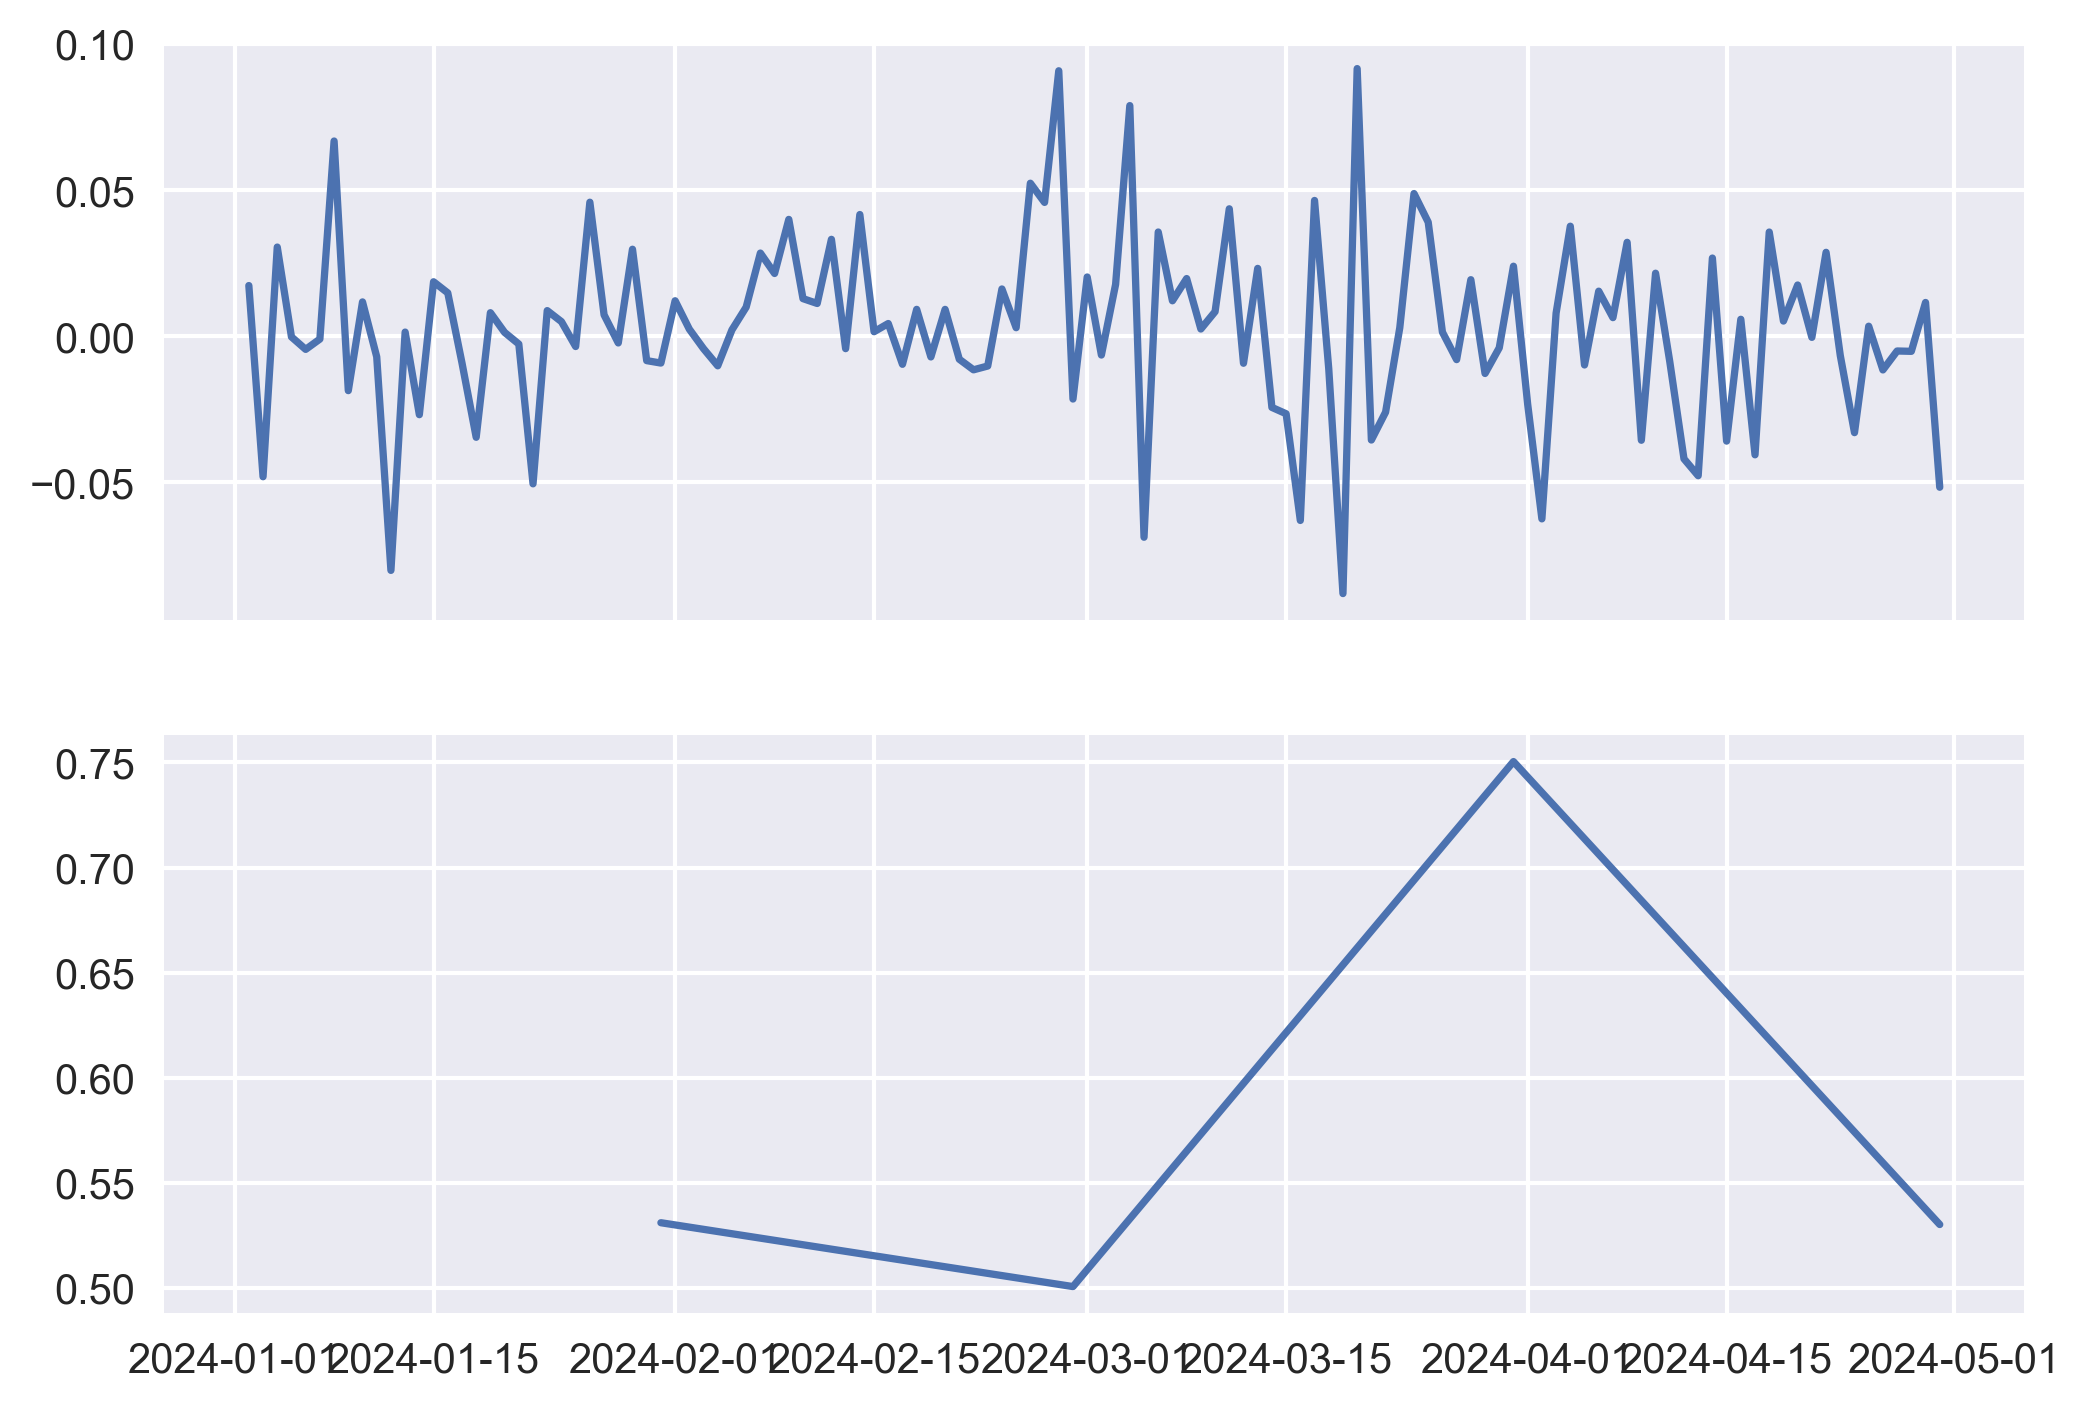

In [12]:
def realized_volatility(x):

    return np.sqrt(np.sum(x**2, axis = 0))

df_rv = df_Bybit.groupby(pd.Grouper(freq='ME'))['log_rtn'].apply(realized_volatility) 
# Rename the Series
df_rv.rename('rv', inplace=True)  # Change the name of the Series

df_rv = df_rv.reset_index()
df_rv.rename(columns={'log_rtn': 'rv'}, inplace=True)  # Now renaming the DataFrame column

# Convert the Series to a DataFrame and reset the index


df_rv.rv = df_rv.rv * np.sqrt(12)
df_rv.set_index('startTime', inplace=True)
print(df_rv.head())
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 1, sharex=True) 
ax[0].plot(df_Bybit["log_rtn"]) 
ax[1].plot(df_rv["rv"])

In [13]:
# Creating a new DataFrame to store the filled days
filled_df = pd.DataFrame()

for month_end in df_rv.index:
    # Generate a date range from the start of the month to the month end
    month_range = pd.date_range(start=month_end.replace(day=1), end=month_end)
    # Repeat the value across the new DataFrame
    temp_df = pd.DataFrame(month_range, columns=['Date'])
    temp_df['rv'] = df_rv.loc[month_end, 'rv']
    filled_df = pd.concat([filled_df, temp_df])

filled_df.set_index('Date', inplace=True)

print(filled_df)

                  rv
Date                
2024-01-01  0.531068
2024-01-02  0.531068
2024-01-03  0.531068
2024-01-04  0.531068
2024-01-05  0.531068
...              ...
2024-04-26  0.530214
2024-04-27  0.530214
2024-04-28  0.530214
2024-04-29  0.530214
2024-04-30  0.530214

[121 rows x 1 columns]


In [14]:
import pandas as pd


# Merge datasets on their index
merged_data = df_Bybit.merge(filled_df, how='left', left_index=True, right_index=True)

# Check the merged data
print(merged_data.head(40))  # Printing first 40 entries to see the transition from one month to another

merged_data.to_csv('/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_data_with_ReturnsandVol.csv', index=False) 

            openPrice  highPrice  lowPrice  closePrice  symbol      volume  \
startTime                                                                    
2024-01-01   42280.78   44204.26  42183.19    44196.74  BTCUSD   798428072   
2024-01-02   44196.74   45918.41  44176.98    44972.21  BTCUSD  1678956836   
2024-01-03   44972.21   45514.61  40634.17    42862.50  BTCUSD  1866818165   
2024-01-04   42862.50   44796.20  42650.78    44192.89  BTCUSD  1486944137   
2024-01-05   44192.89   44391.96  42550.61    44184.68  BTCUSD  1580574390   
2024-01-06   44184.68   44251.66  43435.58    43988.40  BTCUSD   446176322   
2024-01-07   43988.40   44498.62  43633.84    43947.84  BTCUSD   378772202   
2024-01-08   43947.84   47301.13  43207.70    46987.03  BTCUSD   810996051   
2024-01-09   46987.03   47912.02  44864.98    46122.13  BTCUSD   922939555   
2024-01-10   46122.13   47714.22  44317.45    46669.28  BTCUSD  1171558723   
2024-01-11   46669.28   49015.99  45578.40    46343.64  BTCUSD  

In [15]:
merged_data

,openPrice,highPrice,lowPrice,closePrice,symbol,volume,turnover,openInterest,simple_rtn,log_rtn,rv
startTime,,,,,,,,,,,
2024-01-01,42280.78,44204.26,42183.19,44196.74,BTCUSD,798428072,18562.576041,73368460.0,NaN,NaN,0.531068
2024-01-02,44196.74,45918.41,44176.98,44972.21,BTCUSD,1678956836,37087.310665,67724170.0,0.017546,0.017394,0.531068
2024-01-03,44972.21,45514.61,40634.17,42862.50,BTCUSD,1866818165,43188.712504,66027182.0,-0.046911,-0.048047,0.531068
2024-01-04,42862.50,44796.20,42650.78,44192.89,BTCUSD,1486944137,34112.228058,67325876.0,0.031039,0.030567,0.531068
2024-01-05,44192.89,44391.96,42550.61,44184.68,BTCUSD,1580574390,36139.427991,70979221.0,-0.000186,-0.000186,0.531068
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,64488.03,64791.93,63308.59,63751.61,BTCUSD,1148931440,17931.562023,319516725.0,-0.011419,-0.011485,0.530214
2024-04-27,63751.61,63907.37,62397.63,63433.42,BTCUSD,912937699,14488.390121,318241311.0,-0.004991,-0.005004,0.530214
2024-04-28,63433.42,64340.59,62767.71,63109.42,BTCUSD,698842508,10994.505878,316996638.0,-0.005108,-0.005121,0.530214
